In [191]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

## Define a plant class

In [192]:
class planet():
    "A planet in our solar system"
    def __init__(self,semimajor,eccentricity):
        self.x = np.zeros(2)
        self.v = np.zeros(2)
        self.a_g = np.zeros(2)
        self.t = 0.0
        self.dt = 0.0
        self.a = semimajor
        self.e = eccentricity
        self.istep = 0
        self.name = ""

## Define a dictionary with some constants

In [193]:
solar_system = { "M_sun":1.0, "G":39.4784176043574320}

## Define some functions for setting circular velocity, and acceleration

In [194]:
def SolarCircularVelocity(p):
    
    G = solar_system["G"]
    M = solar_system["M_sun"]
    r = ( p.x[0]**2 + p.x[1]**2 )**0.5
    
    return (G*M/r)**0.5

## Write a function to compute the gravitational acceleration on each planet from the sun

In [195]:
def SolarGravitationalAcceleration(p):
    
    G = solar_system["G"]
    M = solar_system["M_sun"]
    r = ( p.x[0]**2 + p.x[1]**2 )**0.5
    
    a_grav = -1.0*G*M/r**2
    
    if(p.x[0]==0.0):
        if(p.x[1]>0.0):
            theta = 0.5*np.pi
        else:
            theta = 1.5*np.pi
    else:
        theta = np.arctan2(p.x[1],p.x[0])
    
    return a_grav*np.cos(theta), a_grav*np.sin(theta)

## Compute the timestep

In [196]:
def calc_dt(p):
    
    ETA_TIME_STEP = 0.0004
    
    eta = ETA_TIME_STEP
    v = (p.v[0]**2 + p.v[1]**2)**0.5
    a = (p.a_g[0]**2 + p.a_g[1]**2)**0.5
    dt = eta * np.fmin(1./np.fabs(v),1./np.fabs(a)**0.5)
    
    return dt

## Define the initial conditions

In [197]:
def SetPlanet(p, i):
    AU_in_km = 1.495979e+8
    
    v_c = 0.0
    
    v_e = 0.0
    
    if(i==0):
        p.a = 57909227.0/AU_in_km
        
        p.e = 0.20563593
        
        p.name = "Mercury"
        
    elif(i==1):
        
        p.a = 108209475.0/AU_in_km
        
        p.e = 0.00677672
        
        p.name = "Venus"
        
    elif(i==2):
        
        p.a = 1.0
        
        p.e = 0.01671123
        
        p.name = "Earth"
        
    p.t = 0.0
    p.x[0] = p.a*(1.0-p.e)
    p.x[1] = 0.0
    
    v_c = SolarCircularVelocity(p)
    
    v_e = v_c*(1 + p.e)**0.5
    
    p.v[0] = 0.0
    p.v[1] = v_e
    
    p.ag = SolarGravitationalAcceleration(p)
    
    p.dt = calc_dt(p)

## Write leapfrog integrator

In [198]:
def x_first_step(x_i, v_i, a_i, dt):
    return x_i + 0.5*v_i*dt + 0.25*a_i*dt**2

In [199]:
def v_full_step(v_i, a_ipoh, dt):
    return v_i + a_ipoh*dt;

In [200]:
def x_full_step(x_ipoh, v_ip1, a_ipoh, dt):
    return x_ipoh + v_ip1*dt;

## Write a function to save the data to file

In [201]:
def SaveSolarSystem(p, n_planets, t, dt, istep, ndim):
    
    for i in range(n_planets):
        fname = "planet.%s.txt" % p[i].name
        
        if(istep==0):
            fp = open(fname,"w")
        else:
            fp = open(fname,"a")
            
        v_drift = np.zeros(ndim)
        
        for k in range(ndim):
            v_drift[k] = p[i].v[k] + 0.5*p[i].a_g[k]*p[i].dt
            
        s = "%6d\t%6.5f\t%6.5f\t%6d\t%6.5f\t%6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\n" % \
            (istep,t,dt,p[i].istep,p[i].t,p[i].dt,p[i].x[0],p[i].x[1],v_drift[0],v_drift[1],p[i].a_g[0],p[i].a_g[1])
        fp.write(s)
        
        fp.close()

## Write a function to evolve the solar system

In [202]:
def EvolveSolarSystem(p,n_planets,t_max):
    ndim = 2
    
    dt = 0.5/365.25
    
    t = 0.0
    
    istep = 0
    
    SaveSolarSystem(p,n_planets,t,dt,istep,ndim)
    
    while(t<t_max):
        if(t+dt>t_max):
            dt = t_max - t
        for i in range(n_planets):
            while(p[i].t<t+dt):
                if(p[i].istep==0):
                    for k in range(ndim):
                        p[i].x[k] = x_first_step(p[i].x[k],p[i].v[k],p[i].a_g[k],p[i].dt)
                        
                    p[i].a_g = SolarGravitationalAcceleration(p[i])
                    
                    p[i].t += 0.5*p[i].dt
                    
                    p[i].dt = calc_dt(p[i])
                    
                if(p[i].t + p[i].dt> t+dt):
                    p[i].dt = t+dt-p[i].t
                for k in range(ndim):
                    p[i].v[k] = v_full_step(p[i].v[k],p[i].a_g[k],p[i].dt)
                for k in range(ndim):
                    p[i].x[k] = x_full_step(p[i].x[k],p[i].v[k],p[i].a_g[k],p[i].dt)
                    
                p[i].a_g = SolarGravitationalAcceleration(p[i])
                
                p[i].t += p[i].dt
                
                p[i].dt = calc_dt(p[i])
                
                p[i].istep+=1
                
            t+=dt
            
            istep += 1
            
            SaveSolarSystem(p,n_planets,t,dt,istep,ndim)
            
    print("Time t = ",t)
    print("Maximum t = ",t_max)
    print("Maximum number of steps = ",istep)


## Create a routine to read data

In [203]:
def read_twelve_arrays(fname):
    fp = open(fname,"r")
    fl = fp.readlines()
    n = len(fl)
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n)
    f = np.zeros(n)
    g = np.zeros(n)
    h = np.zeros(n)
    j = np.zeros(n)
    k = np.zeros(n)
    l = np.zeros(n)
    m = np.zeros(n)
    p = np.zeros(n)
    for i in range(n):
        a[i] = float(fl[i].split()[0])
        b[i] = float(fl[i].split()[1])
        c[i] = float(fl[i].split()[2])
        d[i] = float(fl[i].split()[3])
        f[i] = float(fl[i].split()[4])
        g[i] = float(fl[i].split()[5])
        h[i] = float(fl[i].split()[6])
        j[i] = float(fl[i].split()[7])
        k[i] = float(fl[i].split()[8])
        l[i] = float(fl[i].split()[9])
        m[i] = float(fl[i].split()[10])
        p[i] = float(fl[i].split()[11])
        
    return a,b,c,d,f,g,h,j,k,l,m,p

## Perform the integraion of the Solar System

In [204]:
n_planets = 3

t_max = 2.0

p = []

for i in range(n_planets):
    ptmp = planet(0.0,0.0)
    
    SetPlanet(ptmp,i)
    
    p.append(ptmp)
    
EvolveSolarSystem(p,n_planets,t_max)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Time t =  2.000000000000041
Maximum t =  2.0
Maximum number of steps =  1464


In [205]:
fname = "planet.Mercury.txt"
istepMg,tMg,dtMg,istepM,tM,dtM,xM,yM,vxM,vyM,axM,ayM = read_twelve_arrays(fname)

In [206]:
fname = "planet.Venus.txt"
istepVg,tVg,dtVg,istepV,tV,dtV,xV,yV,vxV,vyV,axV,ayV = read_twelve_arrays(fname)

In [207]:
fname = "planet.Earth.txt"
istepEg,tEg,dtEg,istepE,tM,dtE,xE,yE,vxE,vyE,axE,ayE = read_twelve_arrays(fname)

## Plot the data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


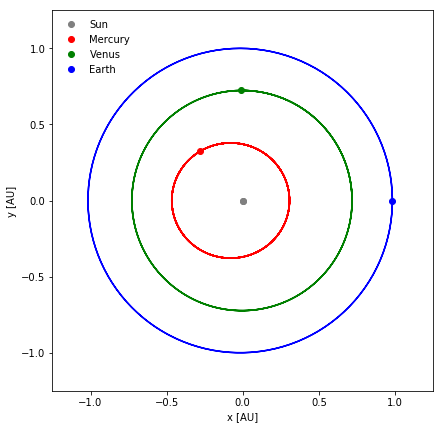

In [211]:
fig = plt.figure(figsize=(7,7))

xSun = [0,0]
ySun = [0,0]
plt.plot(xSun,ySun,'o',color="0.5",label="Sun")

plt.plot(xM,yM,color="red")
plt.plot(xM[-1],yM[-1],'o',color="red",label="Mercury")

plt.plot(xV,yV,color="green")
plt.plot(xV[-1],yV[-1],'o',color="green",label="Venus")

plt.plot(xE,yE,color="blue")
plt.plot(xE[-1],yE[-1],'o',color="blue",label="Earth")


plt.xlim([-1.25,1.25])
plt.ylim([-1.25,1.25])
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.axes().set_aspect('equal')
plt.legend(frameon=False,loc=2)